In [1]:
import json
import os
import pandas as pd
import numpy as np
from pathlib import Path
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import sys
sys.path.append("../")
from datatools.analyzer import *
from utterance.error_tools import *

from datatools.maneger import DataManager
from datatools.preproc import Preprocessor



In [2]:
with open("../../corpus/NTT/persona.json", "r", encoding="utf-8") as f:
    convs = json.load(f)
all_utt = []
for did in tqdm( convs["convs"] ) :
    dids = list( did.keys() )[0]
    all_utt += did[dids]

with open("../../corpus/NTT/empathetic.json", "r", encoding="utf-8") as f:
    convs = json.load(f)
for did in tqdm( convs["convs"] ) :
    dids = list( did.keys() )[0]
    all_utt += did[dids]

100%|██████████| 19999/19999 [00:00<00:00, 1602083.46it/s]


In [3]:
def clean_text_plain(text):
    text_ = neologdn.normalize(text)
    text_ = re.sub(r'\(.*\)', "", text_)
    text_ = re.sub(r'\d+', "0", text_)
    return text_

In [4]:
all_utt = [clean_text_plain(t) for t in tqdm(all_utt)]

100%|██████████| 141777/141777 [00:02<00:00, 53327.67it/s]


In [5]:
sentence = '静岡県の麻生太郎は1年前から射撃が得意だ'

In [6]:
# mecab_analyzer = Analyzer(tokenizer_)
mecab_analyzer = Analyzer(Tokenizer())

In [7]:
def last_pos(pos_split):
    last = len(pos_split) - 1 
    for i, _ in enumerate(pos_split):
        if pos_split[last-i] != "*":
            return "["+pos_split[last-i]+"]"

def sentence2normalize_noun_mecab(sentences):
    normalize_sen = []
    if isinstance(sentences, str):
        sentences = [sentences]
    for sen in sentences:
        df = mecab_analyzer.analyze_with_dataframe(sen)
        words = []
        if df is None:
            continue
        for txt, pos in zip(df.surface, df.part_of_speech):
            pos_split = pos.split("-")
            # print(pos_split)
            if pos_split[0]=="名詞" :
                if pos_split[1] == "固有名詞" :
                    words.append(pos)
                elif pos_split[1] == "数詞":
                    words.append("0")
                else:
                    words.append(txt)
            else:
                words.append(txt)
        normalize_sen.append(words)
    return normalize_sen

In [8]:
class Vocabulary:
    def __init__(self, TOKENS=["[PAD]", "FOS", "EOS", "[SEP]", "[UNK]", "[NONE]"]):
        self.index2item = []
        self.item2index = {}

        for sp_token in TOKENS:
            self.add_item(sp_token)

    # 単語数
    def __len__(self):
        return len(self.item2index)

    # 単語が含まれているか
    def __contains__(self, item):
        return item in self.item2index.keys()
    
    def __str__(self) -> str:
        return str(self.item2index)

    # 単語の追加
    def add_item(self, item):
        # もう登録されてたら登録しないよ
        if item in self.item2index:
            return
        index = len(self.item2index)
        self.index2item.append(item)
        self.item2index[item] = index
    
    def add_items(self, items:list):
        for item in items:
            self.add_item(item)

    # 単語の取得
    def get_item(self, index):
        if len(self.index2item) <= index:
            return "[UNK]"
        return self.index2item[index]

    # 単語をidへ
    def get_index(self, item):
        if item not in self.item2index:
            return self.item2index["[UNK]"]
        return self.item2index[item]

    # def save_vocab(self, )

In [9]:
sentence2normalize_noun_mecab(sentence)

[['名詞-固有名詞-地名-一般',
  '県',
  'の',
  '名詞-固有名詞-人名-姓',
  '名詞-固有名詞-人名-名',
  'は',
  '0',
  '年',
  '前',
  'から',
  '射撃',
  'が',
  '得意',
  'だ']]

In [10]:
TOKENS = ["[PAD]", "FOS", "EOS", "[SEP]", "[UNK]", "[NONE]"]
vocab = Vocabulary(TOKENS=TOKENS)

In [11]:
normalized = sentence2normalize_noun_mecab(all_utt)

[8208] 2022-02-01 17:06:58,839 Info wakame.analyzer :text is empty!


In [12]:
import itertools
flattened = list(itertools.chain.from_iterable(normalized))
vocab.add_items(flattened)

In [13]:
def sentence2ids(sentence, vocab):
    normalized = sentence2normalize_noun_mecab(sentence)[0]
    ids = [ vocab.get_index(c) for c in normalized]
    return ids

In [14]:
sentence = "手を貯金に出すのは駄目でしょうが"
sentence2ids(sentence, vocab)

[1637, 30, 693, 46, 3590, 19, 26, 1623, 111, 21]

In [15]:
len(vocab)

26420

In [16]:
def sentence2gram(sentence, vocab, N=5, is_id=True):
    normalized = sentence2normalize_noun_mecab(sentence)
    if len(normalized)==0:
        return []
    normalized = ["FOS"] + normalized[0] + ["EOS"]
    # padding
    if len(normalized) < N:
        normalized += ["[PAD]"]*(N-len(normalized)) 
    # id化を同時に行う場合
    if is_id:
        normalized = [ vocab.get_index(c) for c in normalized]
    ngram_text = []
    for i in range(len(normalized)-N+1):
            # print(L[i:i+N])
        ngram_text.append(normalized[i:i+N])
    return ngram_text


In [17]:
def make_X_y_seq(A, vocab, N=5, is_id=True):
    X = []
    Y = []
    for utt in tqdm(A):
        # ngram にした結果がかえってくる
        ngram_text = sentence2gram(utt, vocab, N, is_id)
        X.extend(ngram_text[:-1])
        Y.extend(ngram_text[1:])
    return X, Y     


In [18]:
sentence2gram(sentence, vocab, N=5, is_id=False)

[['FOS', '手', 'を', '貯金', 'に'],
 ['手', 'を', '貯金', 'に', '出す'],
 ['を', '貯金', 'に', '出す', 'の'],
 ['貯金', 'に', '出す', 'の', 'は'],
 ['に', '出す', 'の', 'は', '駄目'],
 ['出す', 'の', 'は', '駄目', 'でしょう'],
 ['の', 'は', '駄目', 'でしょう', 'が'],
 ['は', '駄目', 'でしょう', 'が', 'EOS']]

In [19]:
X, Y = make_X_y_seq(all_utt, vocab, N=5, is_id=True)

100%|██████████| 141777/141777 [02:50<00:00, 833.52it/s] 


In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules import loss
import torch.optim as optim
import torch.nn.utils.rnn as rnn

class Datasets(torch.utils.data.Dataset):
    def __init__(self, X_data, y_data):
        # self.transform = transform

        self.X_data = X_data
        self.y_data = y_data

        self.datanum = len(X_data)

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        out_X = self.X_data[idx]
        out_y = self.y_data[idx]

        return out_X, out_y

In [22]:
X_train, X_test, y_train, y_test = train_test_split(torch.tensor(X), torch.tensor(Y), test_size=0.20, random_state=5)

In [23]:
class LMN5(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        # 親クラスのコンストラクタ。決まり文句
        super(LMN5, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。    
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        self.embed = nn.Embedding(vocab_size, embedding_dim,  padding_idx=0)
        # モデルを2つ定義
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        # self.lstm2 = nn.LSTM(embedding_dim, hidden_dim//2, batch_first=True,  bidirectional=True )
        self.linear = nn.Linear(embedding_dim, vocab_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.Softmax()

        nn.init.normal_(self.embed.weight, std=0.01)
        self.linear.weight = self.embed.weight
        nn.init.zeros_(self.linear.bias)
    
    def forward(self, x):
        emb_out = self.embed(x)
        # y =self.softmax(tag_space)
        out, hc = self.lstm1(emb_out)
        y = self.linear(out)
        # print(y.shape)
        return y

In [24]:
BATCH_SIZE = 256
epoch_ = 300
trainset = Datasets(X_train, y_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 2)

In [25]:
VOCAB_SIZE = len(vocab)
EMBEDDING_DIM = 256
HIDDEN_DIM = EMBEDDING_DIM
OUTPUT_DIM = len(vocab)

In [26]:
len(X_train)

1908041

In [27]:
model = LMN5(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM)
if torch.cuda.is_available():
   model.cuda()
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0002)

In [28]:
losses = []
import math
for epoch in tqdm(range(epoch_)):  # again, normally you would NOT do 300 epochs, it is toy data
    all_loss =  0
    for data in tqdm(trainloader):
        # X_t_tensor = torch.tensor(data[0], device='cuda:0', dtype=torch.int16)
        # X_t_tensor = data[0].to(torch.int).cuda()
        # y_t_tensor = data[1].to(torch.long).cuda()
        X_t_tensor = data[0].to(torch.int).cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        # y_t_tensor = F.one_hot(data[1], num_classes=VOCAB_SIZE)
        optimizer.zero_grad()
        model.zero_grad()

        score_ = model(X_t_tensor)
        # print(score_.view(-1, VOCAB_SIZE).shape,  y_t_tensor.view(-1).shape)
        loss_ = loss_function(score_.view(-1, VOCAB_SIZE),  y_t_tensor.view(-1))
        loss_.backward()
        all_loss += loss_.item()
        optimizer.step()
        del score_
        del loss_
    ppl = math.exp(all_loss / len(trainloader))
    losses.append(ppl)
    if (epoch+1) % 20 == 0:
        print("epoch", epoch+1, "\t" , "loss", ppl)
print("done")

  0%|          | 0/300 [07:31<?, ?it/s]


NameError: name 'math' is not defined

In [33]:
450*100/3600

12.5

In [ ]:
import math
def eval_perplexity(model, iterator):
    total_loss = 0
    hidden = None

    model.eval()
    with torch.no_grad():
        X_t_tensor = data[0].to(torch.int).cuda()
        y_t_tensor = data[1].to(torch.long).cuda()
        score_ = model(X_t_tensor)
        loss_ = loss_function(score_.view(-1, VOCAB_SIZE),  y_t_tensor.view(-1))
        total_loss += loss.item()
      
    ppl = math.exp(total_loss / len(iterator))
    return ppl

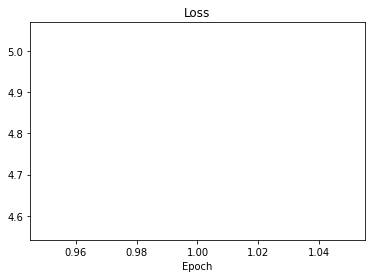

In [ ]:
from matplotlib import pyplot as plt
def plot_history(losses):
    fig, ax = plt.subplots()

    epochs = np.arange(1, len(losses) + 1)

    # 損失の推移
    ax.set_title("Loss")
    ax.plot(epochs, losses)
    ax.set_xlabel("Epoch")

    plt.show()
plot_history(losses)

In [ ]:
model_path = "../models/CF/"
model_name = "ffn_CF1.pickle"
modelM = DataManager(model_path)
modelM.save_data(model_name, model)

In [ ]:
# vocab_path = "../models/base/"
vocab_name = "vocab_CF1.pickle"
modelM.save_data(vocab_name, vocab)